In [1]:
from snow import SnowModel
from srfebal import SrfebalModel
from soil import SoilModel
from thermal import Thermal
from swrad import SWrad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
#fforc = r'/Users/jpnousu/Documents/Forc_test/FORCING_LOMPOLO.nc'
#forc = xr.open_dataset(fforc).sel(time=slice('2020-10-01', '2021-07-01'))
#forc = forc.to_dataframe()

In [3]:
fforc = r'/Users/jpnousu/FSM2/met_Sod_1314.txt'
fout = r'/Users/jpnousu/FSM2/Sod_1314_stat.txt'
foutf = r'/Users/jpnousu/FSM2/Sod_1314_flux.txt'
forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))
out = pd.read_csv(fout, header=None, delimiter=r"\s+")
outf = pd.read_csv(foutf, header=None, delimiter=r"\s+")
col_names = ['DIR_SWdown', 'LWdown', 'Snowf', 'Rainf', 'Tair', 'HUMREL', 'Wind', 'PSurf']
forc.columns = col_names

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_74863/1337717768.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))


In [4]:
srfebal = SrfebalModel()
snow = SnowModel()
soil = SoilModel()
thermal = Thermal()
swrad = SWrad()

In [5]:
dt = 3600
Ncnpy = 0
cveg = np.zeros(Ncnpy) 
Ds1 = np.array(5)
fcans = np.zeros(Ncnpy)
lveg = np.zeros(Ncnpy)
fsnow = np.zeros(1)
gs1 = np.zeros(1)
ks1 = np.zeros(1)
Sveg = np.zeros(1)
SWveg = np.zeros(1)
tdif = np.zeros(1)
Ts1 = np.zeros(1)
Tveg0 = np.zeros(1)
Ua = np.zeros(1)+0.1
VAI = np.zeros(1)
vegh = np.zeros(1)
zT = np.zeros(1)
zU = np.zeros(1)
Sice = np.ones(shape=3)
Sliq = np.ones(shape=3)
Tsoil = np.ones(3)+273.15
Tsnow = np.ones(3)+273.15
Tsrf = np.ones(1)+273.15
ksoil = np.ones(3)*0.24
Nsnow = np.zeros(1)
Rgrn = np.zeros(3)
Dsnw = np.zeros(3)
Vsmc = np.zeros(3)+0.3
alb0 = np.zeros(1)+0.2
albs = 0.9
elev = np.zeros(1)+100

# outputs
Tsoillist = []
swelist = []
hslist = []
Meltlist = []
Gsrflist = []
Esrflist = []
Hlist = []
LElist = []
subllist = []
Tsrflist = []
LWoutlist = []
ksnowlist = []

for i in range(len(forc)):
#for i in range(len(forc['time'])):
    
    d_forc = forc.iloc[i]
    #d_forc = forc.isel(time=i)

    print('step', i)

    LW = np.array(d_forc['LWdown'].data)
    Ps = np.array(d_forc['PSurf'].data)
    SWsrf = np.array(d_forc['DIR_SWdown'].data)
    Ta = np.array(d_forc['Tair'].data)
    Rf = np.array(d_forc['Rainf'].data)
    Sf = np.array(d_forc['Snowf'].data)
    Ua = np.array(d_forc['Wind'].data)
    RH = np.array(d_forc['HUMREL'].data)

    albs, fsnow, SWout, SWsrf, SWsub, SWveg, tdif = swrad.run_timestep(albs=albs, alb0=alb0, 
                                                                       dt=dt, elev=elev, Sdif=SWsrf*0.3, 
                                                                       Sdir=SWsrf*0.7, Sf=Sf, Tsrf=Tsrf, 
                                                                       Dsnw=Dsnw, fcans=fcans, lveg=lveg)

    Ds1, gs1, ks1, Ts1, csoil, ksnow, ksoil = thermal.run_timestep(Nsnow=Nsnow, Dsnw=Dsnw,
                                                                   Sice=Sice, Sliq=Sliq,
                                                                   Tsnow=Tsnow, Tsoil=Tsoil,
                                                                   Vsmc=Vsmc)

    Esrf, Gsrf, H, LE, LWout, LWsub, Melt, subl, Usub, Eveg, Tsrf = srfebal.run_timestep(cveg=cveg, Ds1=Ds1, 
                                                                                      dt=dt, fcans=fcans, 
                                                                                      fsnow=fsnow, gs1=gs1, 
                                                                                      ks1=ks1, lveg=lveg, LW=LW, 
                                                                                      Ps=Ps, RH=RH, SWsrf=SWsrf, 
                                                                                      Sveg=Sveg, SWveg=SWveg, 
                                                                                      Ta=Ta, tdif=tdif, Ts1=Ts1, 
                                                                                      Tveg0=Tveg0, Ua=Ua, VAI=VAI, 
                                                                                      vegh=vegh, zT=zT, zU=zU, Sice=Sice)
    
    Gsoil, Roff, hs, swe, Wflx, Sice, Sliq, Dsnw, Rgrn, Tsnow, Tsoil, Nsnow = snow.run_timestep(dt=dt, 
                                                                                                drip=0, 
                                                                                                Esrf=Esrf, 
                                                                                                Gsrf=Gsrf,
                                                                                                ksoil=ksoil, 
                                                                                                Melt=Melt, 
                                                                                                Rf=Rf, 
                                                                                                Sf=Sf, 
                                                                                                Ta=Ta, 
                                                                                                trans=0, 
                                                                                                Tsrf=Tsrf,
                                                                                                unload=0, 
                                                                                                Tsoil=Tsoil,
                                                                                                ksnow=ksnow)

    Tsoil = soil.run_timestep(dt, Gsoil, csoil, ksoil, Tsoil)
    
    swelist.append(swe)
    hslist.append(hs)
    Meltlist.append(Melt)
    Gsrflist.append(Gsrf)
    Tsoillist.append(Tsoil[0])
    Esrflist.append(Esrf)
    Hlist.append(H)
    LElist.append(LE)
    subllist.append(subl)
    Tsrflist.append(Tsrf)
    LWoutlist.append(LWout)
    ksnowlist.append(ksnow[0])

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

/Users/jpnousu/pyFSM2/src/srfebal.py:514: RuntimeWarning: invalid value encountered in power
  2 * np.log((1 + (1 - 16 * zeta) ** 0.25) / 2) +
/Users/jpnousu/pyFSM2/src/srfebal.py:515: RuntimeWarning: invalid value encountered in sqrt
  np.log((1 + (1 - 16 * zeta) ** 0.5) / 2) -
/Users/jpnousu/pyFSM2/src/srfebal.py:516: RuntimeWarning: invalid value encountered in power
  2 * np.arctan((1 - 16 * zeta) ** 0.25) +
/Users/jpnousu/pyFSM2/src/srfebal.py:528: RuntimeWarning: invalid value encountered in sqrt
  2 * np.log((1 + (1 - 16 * zeta) ** 0.5) / 2))


step 2393
step 2394
step 2395
step 2396
step 2397
step 2398
step 2399
step 2400
step 2401
step 2402
step 2403
step 2404
step 2405
step 2406
step 2407
step 2408
step 2409
step 2410
step 2411
step 2412
step 2413
step 2414
step 2415
step 2416
step 2417
step 2418
step 2419
step 2420
step 2421
step 2422
step 2423
step 2424
step 2425
step 2426
step 2427
step 2428
step 2429
step 2430
step 2431
step 2432
step 2433
step 2434
step 2435
step 2436
step 2437
step 2438
step 2439
step 2440
step 2441
step 2442
step 2443
step 2444
step 2445
step 2446
step 2447
step 2448
step 2449
step 2450
step 2451
step 2452
step 2453
step 2454
step 2455
step 2456
step 2457
step 2458
step 2459
step 2460
step 2461
step 2462
step 2463
step 2464
step 2465
step 2466
step 2467
step 2468
step 2469
step 2470
step 2471
step 2472
step 2473
step 2474
step 2475
step 2476
step 2477
step 2478
step 2479
step 2480
step 2481
step 2482
step 2483
step 2484
step 2485
step 2486
step 2487
step 2488
step 2489
step 2490
step 2491
step 2492


Text(0, 0.5, 'Snow depth [m]')

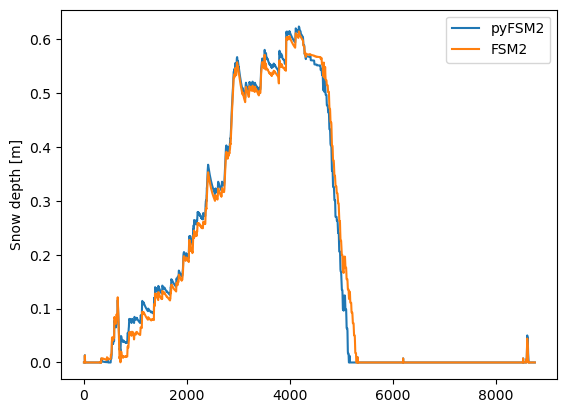

In [6]:
plt.plot(hslist, label='pyFSM2')
plt.plot(out.iloc[:,4], label='FSM2')
plt.legend()
plt.ylabel('Snow depth [m]')

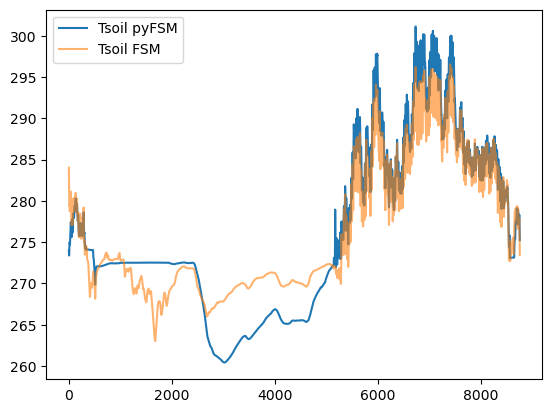

In [7]:
plt.plot(Tsoillist, label='Tsoil pyFSM')
#plt.plot(out.iloc[:,10], label='Tsoil FSM2')
plt.plot(out.iloc[:,7], label='Tsoil FSM', alpha=0.6)
plt.legend()

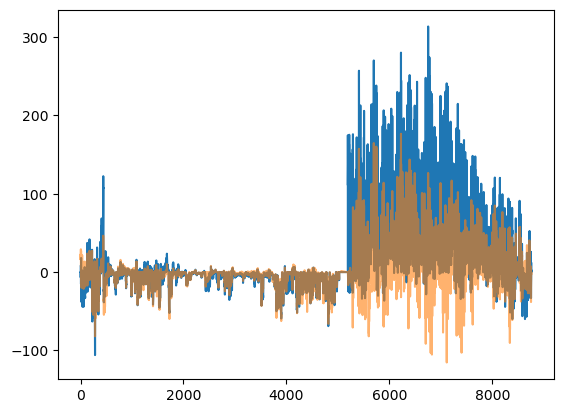

In [8]:
plt.plot(Hlist)
plt.plot(outf.iloc[:,4], alpha=0.6)


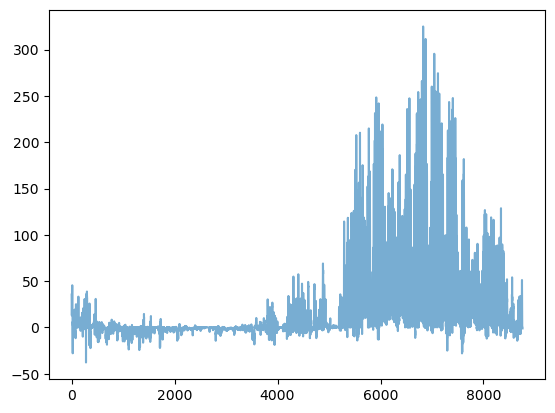

In [9]:
#plt.plot(LElist)
plt.plot(outf.iloc[:,5], alpha=0.6)


ValueError: Input could not be cast to an at-least-1D NumPy array

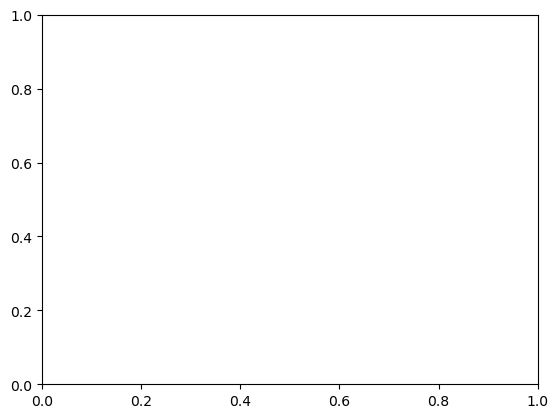

In [10]:
plt.plot(LWoutlist)
plt.plot(outf.iloc[:,6], alpha=0.6)

ValueError: Input could not be cast to an at-least-1D NumPy array

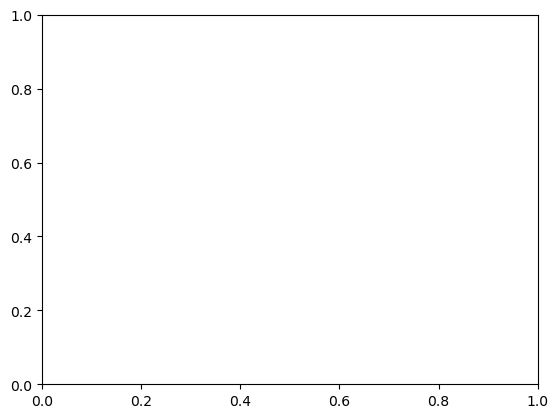

In [10]:
plt.plot(Meltlist)
plt.plot(outf.iloc[:,7], alpha=0.6)

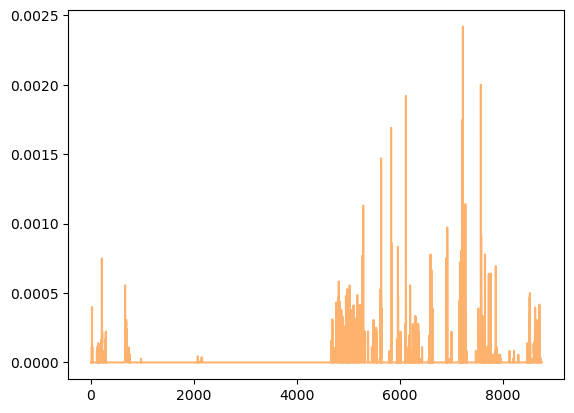

In [11]:
plt.plot(Roff)
plt.plot(outf.iloc[:,8], alpha=0.6)

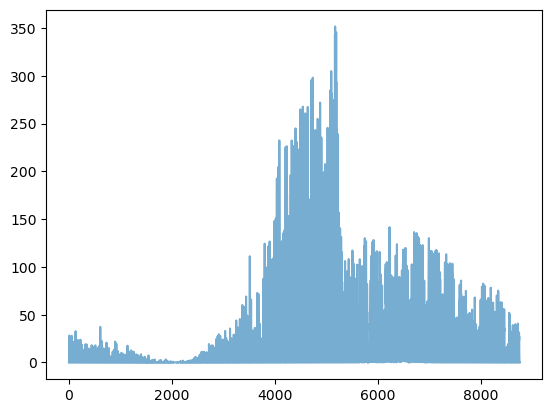

In [13]:
#plt.plot(SWout)
plt.plot(outf.iloc[:,10], alpha=0.6)

In [7]:
ksnowlist

[0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.22988378973557358,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.22988378973557358,
 0.2599061908343191,
 1.4683752766667193,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.24,
 0.2

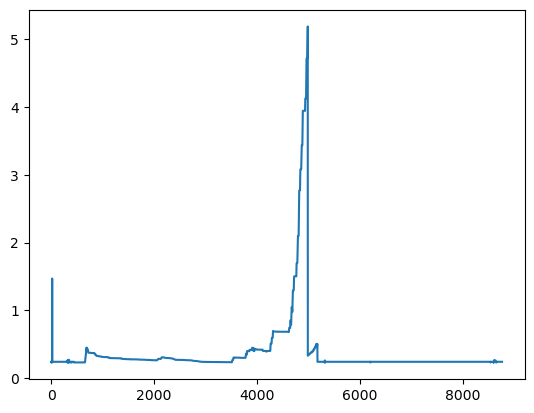

In [8]:
plt.plot(ksnowlist)